In [ ]:
%cd drive/'My Drive'/speech
%ls
!nvidia-smi

[Errno 2] No such file or directory: 'drive/My Drive/speech'
/content/drive/My Drive/speech
iemocap128-mal.pk  iemocap128.pk  iemocap1.pk  logs/  ravdess-mfccs.pk
Fri Jun  5 19:42:59 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 440.82       Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   34C    P8    25W / 149W |      0MiB / 11441MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+----

In [ ]:
import numpy as np
import pickle as pk

dataset = ()
with open('ravdess-mfccs.pk','rb') as f:
  dataset = pk.load(f)
x , y = dataset

print(x[0].shape)
x = [ xi.T for xi in x  ] #in order to padding

c = 9

frames = 1 + 2*c 
x_nuevo = []
mini = 0
for xi in x:
  new_xi = []
  # print(xi.shape)
  for i in range( len(xi) - frames ):
    # print ( xi[i:i+frames] )
    auch = xi[i:i+frames].flatten()
    # print(auch.shape)
    new_xi.append(auch)
    # break

  # print ( np.array(new_xi).shape )
  # break
  # print ( new_xi  ) 
  x_nuevo.append(new_xi)

print ( len(x_nuevo) )
print ( len(x_nuevo[0]) )
print ( len(x_nuevo[0][0]) )

(26, 351)
1440
332
494


In [ ]:

from sklearn.preprocessing import LabelBinarizer
import keras

x_padded = keras.preprocessing.sequence.pad_sequences(x_nuevo, padding='post', value=0)

label_encoder = LabelBinarizer()
y_encoded = label_encoder.fit_transform(y)
print ( x_padded.shape )
print ( y_encoded.shape )
label_encoder.inverse_transform( y_encoded[0].reshape(1,-1) )

Using TensorFlow backend.


(1440, 509, 494)
(1440, 8)


array(['surprised'], dtype='<U9')

In [ ]:
from keras.models import Sequential
from keras.layers import Masking,LSTM,Dense,Softmax, Dropout , Bidirectional, Conv1D
from keras.backend import maximum, minimum
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(x_padded , y_encoded , test_size=0.2, random_state=42 )

def clip_relu(x):
    return minimum( maximum( 0.0, x ) , 20.0 )

model = Sequential()
model.add(  Masking(mask_value=0) )
model.add( Dense (128, activation=clip_relu ) ) # 3   #128 
model.add( Dropout(0.15)) 
model.add( Dense (120, activation=clip_relu) ) # 3 
model.add( Dropout(0.15))
model.add( Dense (120, activation=clip_relu) ) # 3 
model.add( Dropout(0.15)) 
model.add( Dense (120, activation=clip_relu) ) # 3 
model.add( Bidirectional ( LSTM (120, input_shape=(509,120 ) ) )  ) #2048
model.add( Dropout(0.15))
model.add( Dense (120, activation="relu") ) # 3 
model.add( Dropout(0.15)) 
model.add( Dense (8,activation="sigmoid"  ) )


# logdir = os.path.join("logs", datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
# tensorboard_callback = keras.callbacks.TensorBoard(logdir, histogram_freq=1)

model.compile( optimizer="adam" , loss="categorical_crossentropy", metrics=["accuracy"] )
history = model.fit(x_train, y_train, batch_size=1200, validation_data=(x_test, y_test) , epochs=400)
model.summary() 

Train on 1152 samples, validate on 288 samples
Epoch 1/400
1152/1152 [==============================] - 7s 6ms/step - loss: 2.0963 - accuracy: 0.1172 - val_loss: 2.0678 - val_accuracy: 0.1528
Epoch 2/400
1152/1152 [==============================] - 5s 5ms/step - loss: 2.0793 - accuracy: 0.1554 - val_loss: 2.0810 - val_accuracy: 0.1389
Epoch 3/400
1152/1152 [==============================] - 5s 5ms/step - loss: 2.0732 - accuracy: 0.1293 - val_loss: 2.0852 - val_accuracy: 0.1042
Epoch 4/400
1152/1152 [==============================] - 5s 5ms/step - loss: 2.0658 - accuracy: 0.1632 - val_loss: 2.0841 - val_accuracy: 0.1042
Epoch 5/400
1152/1152 [==============================] - 5s 5ms/step - loss: 2.0701 - accuracy: 0.1311 - val_loss: 2.0745 - val_accuracy: 0.1076
Epoch 6/400
1152/1152 [==============================] - 5s 4ms/step - loss: 2.0642 - accuracy: 0.1432 - val_loss: 2.0687 - val_accuracy: 0.1042
Epoch 7/400
1152/1152 [==============================] - 5s 5ms/step - loss: 2.0652

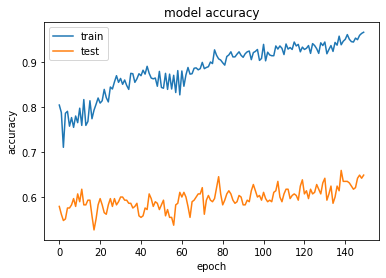

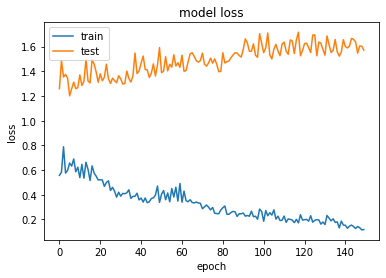

In [ ]:
import matplotlib.pyplot as plt
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [ ]:
history = model.fit(x_train, y_train, batch_size=1200, validation_data=(x_test, y_test) , epochs=150)


Train on 1152 samples, validate on 288 samples
Epoch 1/150
1152/1152 [==============================] - 5s 5ms/step - loss: 0.5573 - accuracy: 0.8047 - val_loss: 1.2588 - val_accuracy: 0.5799
Epoch 2/150
1152/1152 [==============================] - 5s 5ms/step - loss: 0.5825 - accuracy: 0.7882 - val_loss: 1.4864 - val_accuracy: 0.5625
Epoch 3/150
1152/1152 [==============================] - 5s 5ms/step - loss: 0.7885 - accuracy: 0.7109 - val_loss: 1.3532 - val_accuracy: 0.5486
Epoch 4/150
1152/1152 [==============================] - 5s 4ms/step - loss: 0.5760 - accuracy: 0.7865 - val_loss: 1.3746 - val_accuracy: 0.5521
Epoch 5/150
1152/1152 [==============================] - 5s 5ms/step - loss: 0.5981 - accuracy: 0.7908 - val_loss: 1.3451 - val_accuracy: 0.5764
Epoch 6/150
1152/1152 [==============================] - 5s 5ms/step - loss: 0.6571 - accuracy: 0.7578 - val_loss: 1.2009 - val_accuracy: 0.5764
Epoch 7/150
1152/1152 [==============================] - 5s 5ms/step - loss: 0.6324

In [ ]:
import tensorflow as tf
import numpy as np
batch_x = np.linspace(1, 60, num=60).reshape( 6 ,  5 , 2  )
# batch_size = tf.shape(input=batch_x)[0]
batch_x = tf.convert_to_tensor(batch_x, dtype=tf.float32)
print (batch_x)
batch_size = 6
n_context = 1
window_width = 2 *n_context  + 1
num_channels = 2

eye_filter = tf.constant(np.eye(window_width * num_channels)
                               .reshape(window_width, num_channels, window_width * num_channels), tf.float32) # pylint: disable=bad-continuation
# print ( "Filtro COnv" , eye_filter   )

batch_x = tf.nn.conv1d(input=batch_x, filters=eye_filter, stride=1, padding='SAME')

print ( batch_x)

# print (" :............ :")
batch_x = tf.reshape(batch_x, [batch_size, -1, window_width, num_channels])

print ( "output  \n",batch_x)


batch_x = tf.transpose(a=batch_x, perm=[1, 0, 2, 3])

batch_x = tf.reshape(batch_x, [-1, num_channels + 2*num_channels*n_context])
print ( "pre \n",batch_x )

pesos = tf.constant (  np.eye( 6 ) ,tf.float32 )
# print ( batch_x.shape ) 
# print ( pesos.shape )
out = tf.matmul( batch_x , pesos )
print ( out )
tf.reshape(out, [-1, batch_size, 6 ])


tf.Tensor(
[[[ 1.  2.]
  [ 3.  4.]
  [ 5.  6.]
  [ 7.  8.]
  [ 9. 10.]]

 [[11. 12.]
  [13. 14.]
  [15. 16.]
  [17. 18.]
  [19. 20.]]

 [[21. 22.]
  [23. 24.]
  [25. 26.]
  [27. 28.]
  [29. 30.]]

 [[31. 32.]
  [33. 34.]
  [35. 36.]
  [37. 38.]
  [39. 40.]]

 [[41. 42.]
  [43. 44.]
  [45. 46.]
  [47. 48.]
  [49. 50.]]

 [[51. 52.]
  [53. 54.]
  [55. 56.]
  [57. 58.]
  [59. 60.]]], shape=(6, 5, 2), dtype=float32)
tf.Tensor(
[[[ 0.  0.  1.  2.  3.  4.]
  [ 1.  2.  3.  4.  5.  6.]
  [ 3.  4.  5.  6.  7.  8.]
  [ 5.  6.  7.  8.  9. 10.]
  [ 7.  8.  9. 10.  0.  0.]]

 [[ 0.  0. 11. 12. 13. 14.]
  [11. 12. 13. 14. 15. 16.]
  [13. 14. 15. 16. 17. 18.]
  [15. 16. 17. 18. 19. 20.]
  [17. 18. 19. 20.  0.  0.]]

 [[ 0.  0. 21. 22. 23. 24.]
  [21. 22. 23. 24. 25. 26.]
  [23. 24. 25. 26. 27. 28.]
  [25. 26. 27. 28. 29. 30.]
  [27. 28. 29. 30.  0.  0.]]

 [[ 0.  0. 31. 32. 33. 34.]
  [31. 32. 33. 34. 35. 36.]
  [33. 34. 35. 36. 37. 38.]
  [35. 36. 37. 38. 39. 40.]
  [37. 38. 39. 40.  0.  0.]]

 [[ 0

<tf.Tensor: shape=(5, 6, 6), dtype=float32, numpy=
array([[[ 0.,  0.,  1.,  2.,  3.,  4.],
        [ 0.,  0., 11., 12., 13., 14.],
        [ 0.,  0., 21., 22., 23., 24.],
        [ 0.,  0., 31., 32., 33., 34.],
        [ 0.,  0., 41., 42., 43., 44.],
        [ 0.,  0., 51., 52., 53., 54.]],

       [[ 1.,  2.,  3.,  4.,  5.,  6.],
        [11., 12., 13., 14., 15., 16.],
        [21., 22., 23., 24., 25., 26.],
        [31., 32., 33., 34., 35., 36.],
        [41., 42., 43., 44., 45., 46.],
        [51., 52., 53., 54., 55., 56.]],

       [[ 3.,  4.,  5.,  6.,  7.,  8.],
        [13., 14., 15., 16., 17., 18.],
        [23., 24., 25., 26., 27., 28.],
        [33., 34., 35., 36., 37., 38.],
        [43., 44., 45., 46., 47., 48.],
        [53., 54., 55., 56., 57., 58.]],

       [[ 5.,  6.,  7.,  8.,  9., 10.],
        [15., 16., 17., 18., 19., 20.],
        [25., 26., 27., 28., 29., 30.],
        [35., 36., 37., 38., 39., 40.],
        [45., 46., 47., 48., 49., 50.],
        [55., 56., 57.,